# Assessing birth-death-mutation model MLE convergence

In [14]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt
import pickle
from gcdyn import bdms
from gcdyn.model import Model
from jax import jit, grad
from tqdm.auto import tqdm
from collections import namedtuple

def plot_curve(*θ_values, range = (-10, 10), **named_θ_values):
    x_array = np.linspace(*range)
    λ = lambda θ: Model.λ(None, x_array, θ)

    plt.figure()

    for θ in θ_values:
        plt.plot(x_array, λ(θ), color = "black", alpha = 0.5)

    for name, θ in named_θ_values.items():
        plt.plot(x_array, λ(θ), label = name)
    
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\lambda_\theta(x)$")
    plt.xlim(*range)
    
    if named_θ_values:
        plt.legend()

    plt.show()


def evolve_trees(num_trees, **evolve_kwargs):
    trees = [bdms.TreeNode() for _ in range(num_trees)]

    seed = evolve_kwargs.pop("seed", None)

    for tree in trees:
        tree.evolve(seed = seed, **evolve_kwargs)

        if seed is not None:
            seed = seed + 1

    summarize_trees(trees)

    return trees


def summarize_trees(trees):
    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")


def prune_trees(trees, ρ, seed = None):
    copied_trees = [tree.copy() for tree in trees]

    for tree in copied_trees:
        # if statement is for not having an error if you call it twice accidentally
        if not tree._sampled:
            tree.sample_survivors(p = ρ, seed = None)
            tree.prune()

    return copied_trees

## Demo usage of gcdyn module

### Example 1

In [2]:
θ = [2, 1, 0, 0]
num_trees = 2

Average of 208.5 nodes per tree, over 2 trees
Solution in 15 iterations: [ 1.8693697   3.5055227  -0.08554897  0.        ]


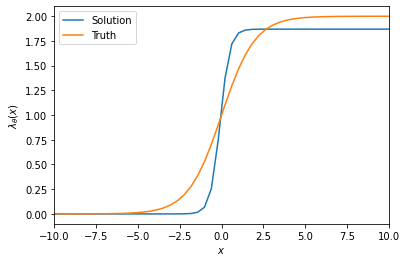

In [3]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit()
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ)

### Example 2

We now try a reverse sigmoid, which is not necessarily biologically motivated (since we expect birth rate to increase with fitness) but statistically as relevant as the previous example.
Note that to reverse the sigmoid, we want to invert `θ[1]`.
In optimization, we also need to relax the constraint on `θ[1]`.

In [4]:
θ = [2, -1, 0, 0]
num_trees = 2

Average of 710.0 nodes per tree, over 2 trees
Solution in 9 iterations: [ 2.0493498  -0.5627433  -0.3167873   0.00596557]


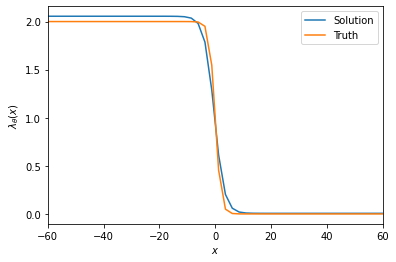

In [5]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

Note that when growing trees, child phenotypes are generated to be smaller than their parent's phenotypes, on average.
This encourages children to have lower birth rates, on average.
But, by reversing the sigmoid, we are actually now encouraging higher birth rates, which is leading to very large trees.
Let's try changing the phenotype shift to be positive (which is toward lower birth rates in this model).

Notice how the JIT compile time drops as the sizes of the trees drops... (or is it just my choice of seed?)

Average of 536.5 nodes per tree, over 2 trees
Solution in 15 iterations: [ 2.087087   -1.1152506   0.46359396  0.        ]


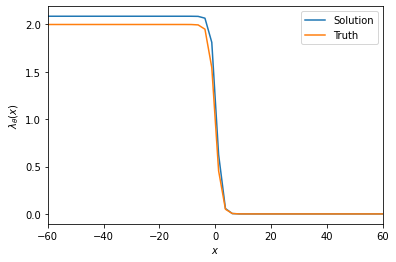

In [6]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 2
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

## Code to try different initial values for MLE runs

Note that this still assumes a single model with a fixed $θ$; we just try to run the algorithm from different starting points.

In [7]:
def try_init_values(model, true_θ, *search_ranges, print_skipped_values = False):
    """
    Runs MLE algorithm for `model` starting from points in the specified range of initial values,
    and plots the resulting log likelihoods against the distance of the initial value from the true parameter value.
    """

    true_θ = np.array(true_θ)

    search_space = itertools.product(*search_ranges)
    search_space = [np.array(t, dtype = float) for t in search_space]

    magnitudes = []
    log_liks = []
    skipped_values = []

    Result = namedtuple("Result", ("θ_init", "θ_result", "magnitude", "log_lik"))
    Result.__repr__ = lambda self: f"θ_init: {self.θ_init}, magnitude: {self.magnitude}, log lik: {self.log_lik}, θ_result: {self.θ_result}"
    results = []

    for θ_init in tqdm(search_space, desc = "Init value #"):
        result = model.fit(init_value = θ_init)
        log_lik = result.state.fun_val

        if np.isnan(log_lik):
            skipped_values.append(θ_init)

        else:
            results.append(Result(
                θ_init    = θ_init,
                θ_result  = result.params,
                magnitude = np.sqrt(np.power(true_θ - θ_init, 2).sum()),
                log_lik   = log_lik
            ))

    magnitudes = np.array([result.magnitude for result in results])
    log_liks = np.array([result.log_lik for result in results])

    plt.scatter(magnitudes, log_liks)
    plt.xlabel(r"$||\theta - \theta\_init||$")
    plt.ylabel("log likelihood of result")
    plt.show()

    if skipped_values:
        print(f"Note: {len(skipped_values)}/{len(search_space)} initial values were skipped.")

        if print_skipped_values:
            for val in skipped_values:
                print(val)
        
        else:
            print("Pass argument `print_skipped_values = True` to see them.")

    return results

Average of 302.0 nodes per tree, over 1 trees


Init value #:   0%|          | 0/1250 [00:00<?, ?it/s]

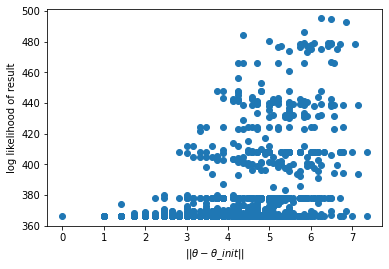

Note: 50/1250 initial values were skipped.
Pass argument `print_skipped_values = True` to see them.


In [8]:
θ = [2, 1, 0, 0]
num_trees = 1

trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

results = try_init_values(model, θ, range(0, 5), range(0, 5), range(-5, 5), range(0, 5))

## MLE on BEAST trees

Average of 55.666666666666664 nodes per tree, over 21 trees
Solution in 6 iterations: [2.0692263  1.2352401  2.377035   0.01314545]


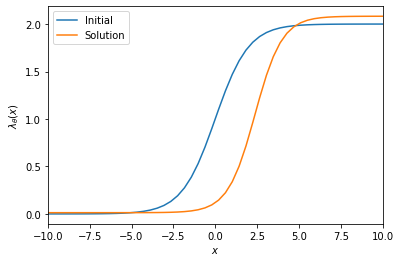

In [9]:
with open("tenseqs_subset-ete3_trees.pickle", "rb") as trees_file:
    beast_trees = pickle.load(trees_file)

some_trees = list(beast_trees.values())[80:]
summarize_trees(some_trees)

model = Model(some_trees, μ = 1, γ = 1, ρ = 0.5)

θ_init = [2, 1, 0, 0]
mle = model.fit(init_value = θ_init)
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")
plot_curve(Initial = θ_init, Solution = mle.params)

## What if we prune the trees?

In reality, we don't observe dead lineages, so we need to prune the trees to see how well inference would go on data we would observe.

### Example 1

In [16]:
θ = [2, 1, 0, 0]
num_trees = 1

Pruning is a random procedure, so we can run independent/parallel prunes and observe the different results we obtain, like a confidence band of sorts

Average of 302.0 nodes per tree, over 1 trees
Truth: [2, 1, 0, 0]
Solution in 13 iterations: [ 1.9068173   2.752452   -0.04683809  0.        ]
Solution after pruning: [ 0.5887804  92.69759     0.85794604  0.14168246]
Solution after pruning: [9.747794  3.7144113 2.7136695 0.5112339]
Solution after pruning: [ 0.55375093 32.24606     0.9452134   0.26961064]
Solution after pruning: [ 0.6504955  65.832794    0.91121256  0.26217002]
Solution after pruning: [ 0.6349471  46.73455     0.73362225  0.2240861 ]
Solution after pruning: [ 0.593497   52.907753    0.93687266  0.22791348]
Solution after pruning: [ 0.7048986  59.08306     0.9005122   0.31415856]
Solution after pruning: [1.4043276  0.4513517  0.9459057  0.02426815]
Solution after pruning: [0.58621573 0.         3.6142972  0.28566635]
Solution after pruning: [ 0.6485041  62.507317    0.9057514   0.17861444]


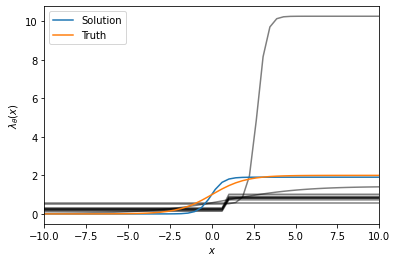

In [17]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(-1, 1),
    min_survivors = 20,
    seed          = 0
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ)
print(f"Truth: {θ}")
print(f"Solution in {mle.state.iter_num} iterations: {mle.params}")

pruned_mles = []

for _ in range(10):
    # Because of JIT, you need to build a new model with the modified trees
    model = Model(prune_trees(trees, ρ = 0.5, seed = 0), μ = 1, γ = 1, ρ = 0.5)

    pruned_mle = model.fit(init_value = θ)
    print(f"Solution after pruning: {pruned_mle.params}")

    pruned_mles.append(pruned_mle)

plot_curve(*[mle.params for mle in pruned_mles], Solution = mle.params, Truth = θ)

The pruned results don't look so good...

### Example 2

In [18]:
θ = [2, -1, 0, 0]
num_trees = 1

Average of 639.0 nodes per tree, over 1 trees
Truth: [2, -1, 0, 0]
Solution: [ 2.0995808  -1.1225653   0.23754703  0.        ]
Solution after pruning: [ 0.9707409  1.2719271 -1.8573182  0.       ]
Solution after pruning: [ 1.19213     0.1403698  -0.19260727  0.06409428]
Solution after pruning: [ 1.5260192  2.1631217 -1.315117   0.       ]
Solution after pruning: [ 1.4171116  -0.1131672  -0.51892525  0.        ]
Solution after pruning: [ 1.6657575  42.424137   -1.3548732   0.38510948]
Solution after pruning: [ 0.29287627 43.43815    -1.4791435   0.39906833]
Solution after pruning: [ 0.7615318  8.845379  -1.7183812  0.       ]
Solution after pruning: [ 0.81436557  0.85014343 -2.427167    0.        ]
Solution after pruning: [12.029894  -7.420811  -3.3738701  0.582621 ]
Solution after pruning: [ 0.7289388 78.11148   -0.5155356  0.5332971]


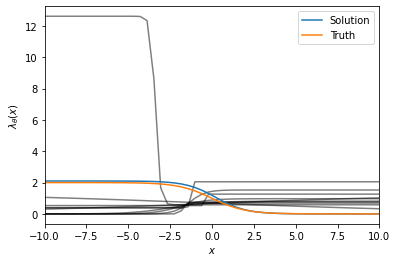

In [20]:
trees = evolve_trees(num_trees,
    t             = 5,
    birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
    death_rate    = bdms.ConstantResponse(1),
    mutation_rate = bdms.ConstantResponse(1),
    mutator       = bdms.GaussianMutator(1, 1),
    min_survivors = 20,
    seed          = 2
)

model = Model(trees, μ = 1, γ = 1, ρ = 0.5)

mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
print(f"Truth: {θ}")
print(f"Solution: {mle.params}")

pruned_mles = []

for _ in range(10):
    # Because of JIT, you need to build a new model with the modified trees
    model = Model(prune_trees(trees, ρ = 0.5, seed = 1), μ = 1, γ = 1, ρ = 0.5)

    pruned_mle = model.fit(init_value = θ, lower_bounds = [0, -np.inf, -np.inf, 0])
    print(f"Solution after pruning: {pruned_mle.params}")

    pruned_mles.append(pruned_mle)

plot_curve(*[mle.params for mle in pruned_mles], Solution = mle.params, Truth = θ)

The pruned results *really* don't look so good here, since most of them aren't even reverse sigmoids...